table of contents  
1. Prepare  
2. Data Read, Preprocess, EDA  
3. Aggregate, Visualize

# Prepare

## Import Library

In [1]:
import os, time, sys, importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Define Static Parameter

In [2]:
base_dir = os.path.join('..')
data_dir = os.path.join(base_dir, 'datasets', 'positional_data')

sys.path.append(os.path.join(base_dir,'..','LaurieOnTracking','src'))
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel

# Data Read Preprocess, EDA

## Read Dataset

In [3]:
os.listdir(data_dir)

['LIV_[2]-1_CHE.csv', 'liverpool_2019.csv', 'Real_vs_Barcelona_Calma.csv']

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'liverpool_2019.csv'), index_col=['play', 'frame'])

In [5]:
df.head()

Unnamed: 0 bgcolor        dx        dy  \
play                          frame                                           
Liverpool [3] - 0 Bournemouth 0               0     NaN  0.000000  0.000000   
                              1               1     NaN  0.185745  1.217580   
                              2               2     NaN  0.178659  1.171133   
                              3               3     NaN  0.171573  1.124685   
                              4               4     NaN  0.164488  1.078238   

                                    edgecolor  player  player_num team  \
play                          frame                                      
Liverpool [3] - 0 Bournemouth 0           NaN       0         NaN  NaN   
                              1           NaN       0         NaN  NaN   
                              2           NaN       0         NaN  NaN   
                              3           NaN       0         NaN  NaN   
                              4           NaN       0         NaN  NaN   

                                             x          y    z  
play                          frame                             
Liverpool [3] - 0 Bournemouth 0      46.394558  11.134454  0.0  
                              1      46.580302  12.352034  0.0  
                              2      46.758961  13.523166  0.0  
                              3      46.930535  14.647852  0.0  
                              4      47.095022  15.726090  0.0

In [6]:
df.index.get_level_values('play').unique()

Index(['Liverpool [3] - 0 Bournemouth', 'Bayern 0 - [1] Liverpool',
       'Fulham 0 - [1] Liverpool', 'Southampton 1 - [2] Liverpool',
       'Liverpool [2] - 0 Porto', 'Porto 0 - [2] Liverpool',
       'Liverpool [4] - 0 Barcelona', 'Liverpool [1] - 0 Wolves',
       'Liverpool [3] - 0 Norwich', 'Liverpool [2] - 1 Chelsea',
       'Liverpool [2] - 1 Newcastle', 'Liverpool [2] - 0 Salzburg',
       'Genk 0 - [3] Liverpool', 'Liverpool [2] - 0 Man City',
       'Liverpool [1] - 0 Everton', 'Liverpool [2] - 0 Everton',
       'Bournemouth 0 - 3 Liverpool', 'Liverpool [1] - 0 Watford',
       'Leicester 0 - [3] Liverpool'],
      dtype='object', name='play')

## Select one

In [7]:
play = 'Liverpool [2] - 0 Man City'
df_tmp = df.loc[play]
df_tmp.tail()

,Unnamed: 0,bgcolor,dx,dy,edgecolor,player,player_num,team,x,y,z
frame,,,,,,,,,,,
162,3669,cyan,0.0,0.0,white,11156,NaN,defense,1.87732,51.118246,0.0
163,3670,cyan,0.0,0.0,white,11156,NaN,defense,1.87732,51.118246,0.0
164,3671,cyan,0.0,0.0,white,11156,NaN,defense,1.87732,51.118246,0.0
165,3672,cyan,0.0,0.0,white,11156,NaN,defense,1.87732,51.118246,0.0
166,3673,cyan,0.0,0.0,white,11156,NaN,defense,1.87732,51.118246,0.0


In [8]:
df_tmp.bgcolor.unique()

array([nan, 'red', 'cyan'], dtype=object)

### split

In [9]:
home_df, away_df = df_tmp[df_tmp.bgcolor.isin(['red', np.nan])], df_tmp[df_tmp.bgcolor.isin(['cyan', np.nan])]

In [10]:
home_df.player.unique()

array([   0,   13, 1057, 1686, 4162, 4163, 4165, 4166, 4167, 4445, 5817])

In [11]:
away_df.player.unique()

array([    0,   262,   263,   264,  2749,  2750,  2751,  2752,  2753,
        2754,  3271, 11156])

## Preprocess

### pivot table

In [12]:
x_size, y_size = 106, 68

def pivot_table_for_Metrica(df):
    df = df.pivot_table(index='frame', columns='player', values=['x', 'y'])
    df.columns = [f'ball_{c_tuple[0]}' if c_tuple[1] == 0 else f'{c_tuple[1]}_{c_tuple[0]}' for c_tuple in df.columns]

    c_x_list, c_y_list = [c for c in df.columns if c.endswith('_x')], [c for c in df.columns if c.endswith('_y')]
    
    df[c_x_list] = df[c_x_list].applymap(lambda x: (x_size/2)*((x-50)/50))
    df[c_y_list] = df[c_y_list].applymap(lambda x: (y_size/2)*((x-50)/50))

    return df

In [13]:
home_df, away_df = pivot_table_for_Metrica(home_df), pivot_table_for_Metrica(away_df)

### check

In [14]:
home_df.columns

Index(['ball_x', '13_x', '1057_x', '1686_x', '4162_x', '4163_x', '4165_x',
       '4166_x', '4167_x', '4445_x', '5817_x', 'ball_y', '13_y', '1057_y',
       '1686_y', '4162_y', '4163_y', '4165_y', '4166_y', '4167_y', '4445_y',
       '5817_y'],
      dtype='object')

In [15]:
home_df[[c for c in home_df.columns if str(c).endswith('_x')]].min().min(), home_df[[c for c in home_df.columns if str(c).endswith('_x')]].max().max()

(-53.72108843537415, 23.920031568637672)

In [16]:
home_df[[c for c in home_df.columns if str(c).endswith('_y')]].min().min(), home_df[[c for c in home_df.columns if str(c).endswith('_y')]].max().max()

(-24.434226417160048, 28.0)

# Visualization

In [17]:
team_color_list = ['#C8102E', '#6CABDD']

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f1cd320>)

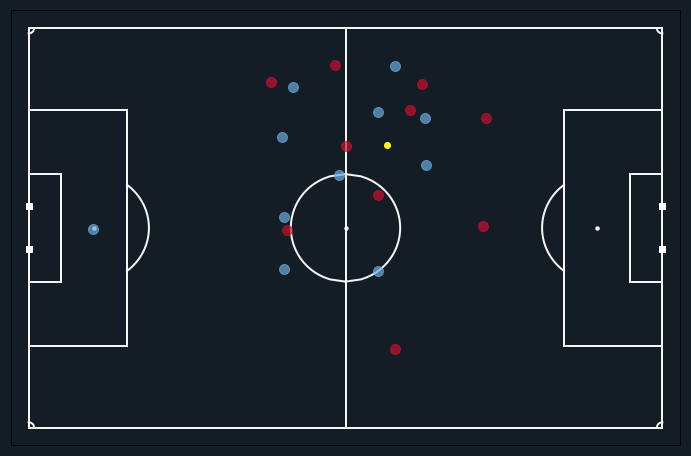

In [18]:
mviz.plot_frame(home_df.iloc[10], away_df.iloc[10], mviz.plot_pitch(field_color='twitter_dark_mode'), team_colors=team_color_list)

In [19]:
mviz.save_match_clip(home_df, away_df, fpath=os.path.join(base_dir, 'reports', 'movie'), fname=play, figax=mviz.plot_pitch(field_color='twitter_dark_mode'), team_colors=team_color_list)

Generating movie...done
